## Предсказание оттока пользователей

### Метрика

В сревновании используется стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить, используя только предсказанные вероятности и истинные классы без конкретного порога классификации, и она раотает даже если классы в данных сильно несбалансированны.  
Но мы также будем обращать внимание на Recall, так как нам важно предсказать всех клиентов, которые собираются перестать пользоваться услугами компании, и попытаться удержать их.


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, make_scorer, recall_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

In [2]:
data = pd.read_csv('./train.csv')

### Анализ данных

Посмотрим, есть ли пропущенные значения.

In [3]:
data.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

Отлично, пропусков нет. Но есть колонка 'TotalSpent', которая по сути является числовой, но по факту - object.

In [5]:
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')

In [6]:
print(f"Пропусков в TotalSpent на трейне: {data['TotalSpent'].isna().sum()}")

Пропусков в TotalSpent на трейне: 9


Все же здесь есть пропуски, заполним их.

In [7]:
data['TotalSpent'].fillna(0, inplace=True)

Посмотрим, есть ли дубликаты, и удалим их.

In [8]:
# Подсчет количества дубликатов
duplicates_count = data.duplicated().sum()

print(f"Количество дубликатов в DataFrame: {duplicates_count}")

Количество дубликатов в DataFrame: 14


In [9]:
data.drop_duplicates(inplace=True)

In [10]:
data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.20,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.90,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570.00,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


Построим гистограммы для численных признаков и столбчатые - для категориальных.  
Также посмотрим на распределение целевой переменной Churn.

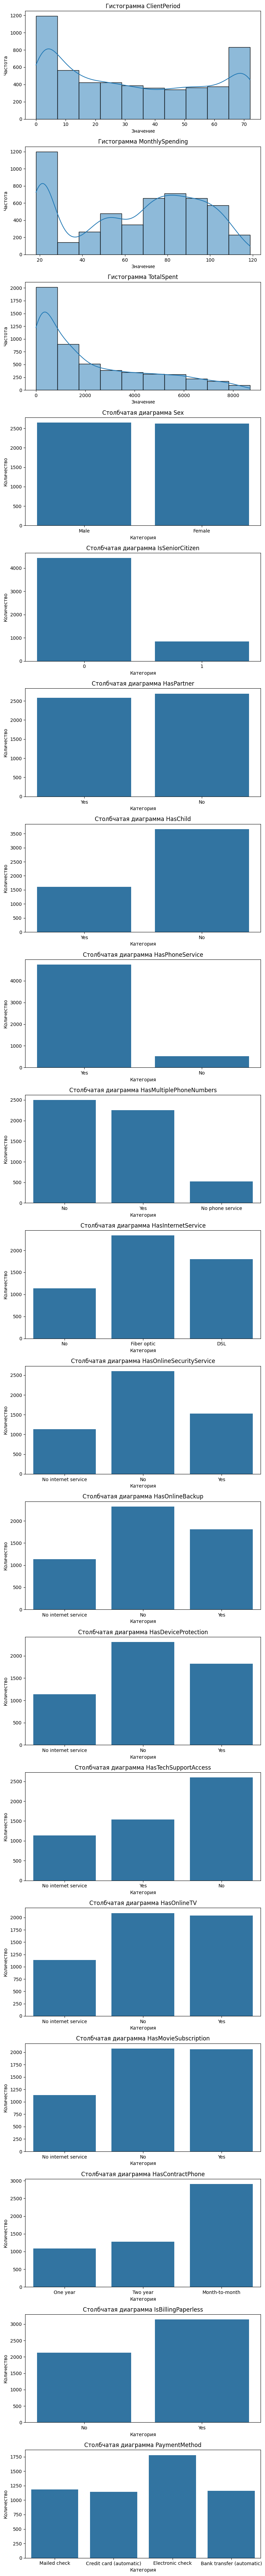

In [11]:
numeric_columns = ['ClientPeriod', 'MonthlySpending', 'TotalSpent']
categorical_columns = ['Sex', 'IsSeniorCitizen', 'HasPartner', 'HasChild', 'HasPhoneService', 'HasMultiplePhoneNumbers', 'HasInternetService', 
                        'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection', 'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription', 
                        'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod']

fig, axes = plt.subplots(len(data.columns)-1, 1, figsize=(8, 4 * (len(data.columns)-1)))

current_index = 0

# Строим гистограммы для числовых признаков
for column in numeric_columns:
    ax = axes[current_index]
    sns.histplot(data[column], bins=10, kde=True, ax=ax)
    ax.set_title(f'Гистограмма {column}')
    ax.set_xlabel('Значение')
    ax.set_ylabel('Частота')
    current_index += 1

# Строим столбчатые диаграммы для категориальных признаков
for column in categorical_columns:
    ax = axes[current_index]
    sns.countplot(x=column, data=data, ax=ax)
    ax.set_title(f'Столбчатая диаграмма {column}')
    ax.set_xlabel('Категория')
    ax.set_ylabel('Количество')
    current_index += 1

plt.tight_layout()
plt.show()

Распределение классов (в процентах):
Churn
0    73.917995
1    26.082005
Name: proportion, dtype: float64


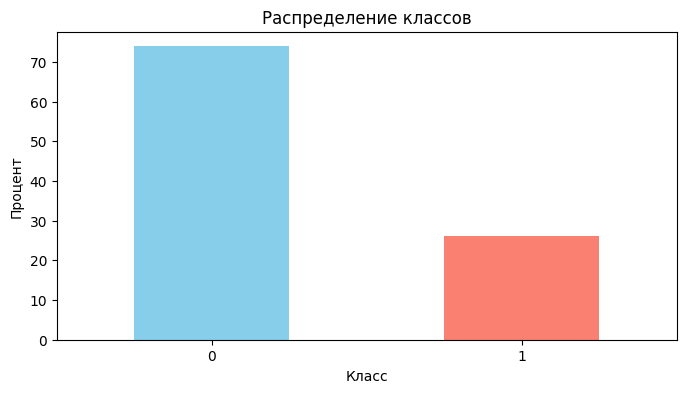

In [12]:
# Распределение классов
class_distribution = data['Churn'].value_counts(normalize=True) * 100

# Вывод распределения классов
print("Распределение классов (в процентах):")
print(class_distribution)

# Визуализация распределения классов
plt.figure(figsize=(8, 4))
class_distribution.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Распределение классов')
plt.xlabel('Класс')
plt.ylabel('Процент')
plt.xticks(rotation=0)
plt.show()

Классы несбалансированы.

Теперь найдем выбросы.

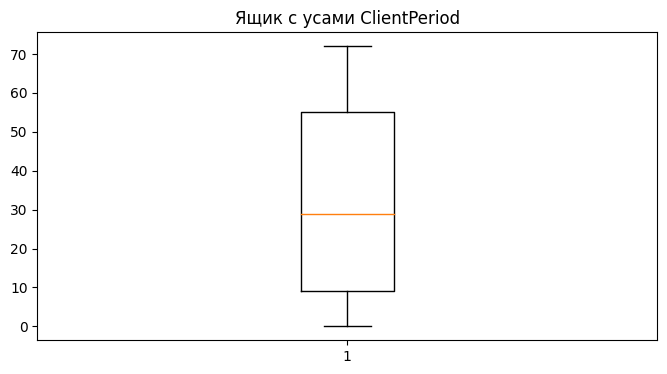

Выбросы в колонке ClientPeriod:
Series([], Name: ClientPeriod, dtype: int64)


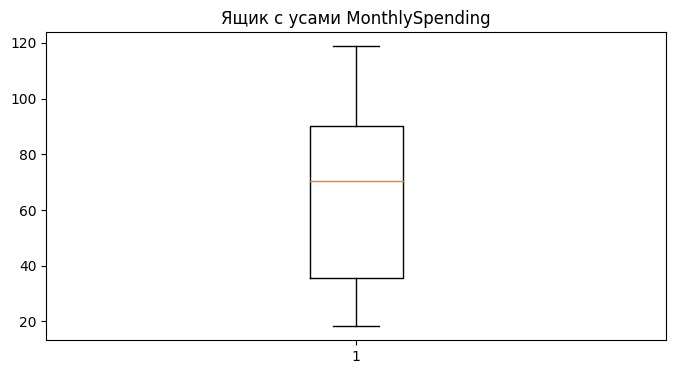

Выбросы в колонке MonthlySpending:
Series([], Name: MonthlySpending, dtype: float64)


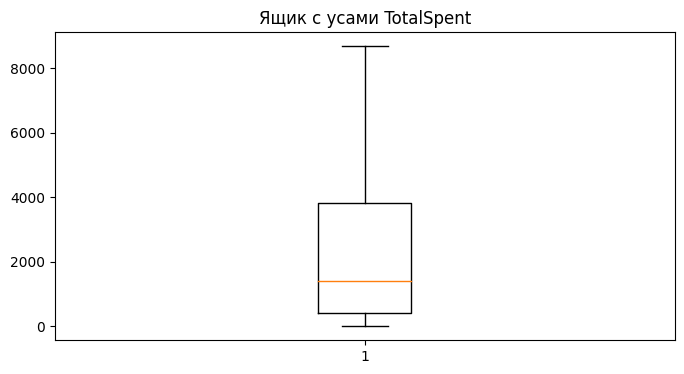

Выбросы в колонке TotalSpent:
Series([], Name: TotalSpent, dtype: float64)


In [13]:
for column in numeric_columns:
    # строим боксплот
    plt.figure(figsize=(8, 4))
    plt.boxplot(data[column])
    plt.title(f'Ящик с усами {column}')
    plt.show()

    # вычисляем Z-score
    z_scores = stats.zscore(data[column])

    # находим выбросы (обычно Z-score > 3 или < -3)
    outliers = data[column][np.abs(z_scores) > 3]

    print(f"Выбросы в колонке {column}:")
    print(outliers)

Выбросов в числовых колонках нет, соответственно, удалять ничего не будем.

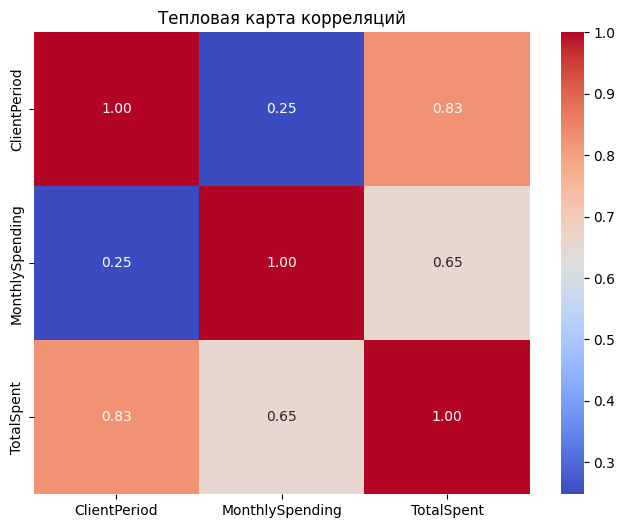

In [14]:
# Тепловая карта корреляций для числовых данных
plt.figure(figsize=(8, 6))
correlation_matrix = data[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Тепловая карта корреляций')
plt.show()

Очевидно, что сумма, потраченная клиентом, связана с продолжительностью его пребывания в статусе клиента.  
TotalSpent является произведением ClientPeriod и MonthlySpending, поэтому мы ее исключим, чтобы избежать мультиколлинеарности.


Теперь посмотрим на связь признаков с целвой переменной:

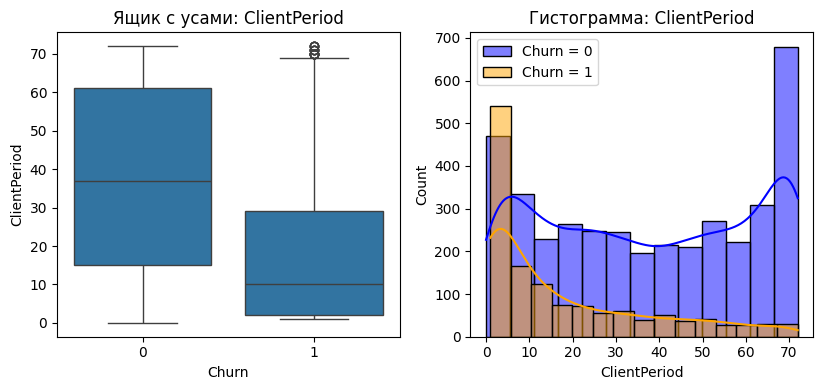

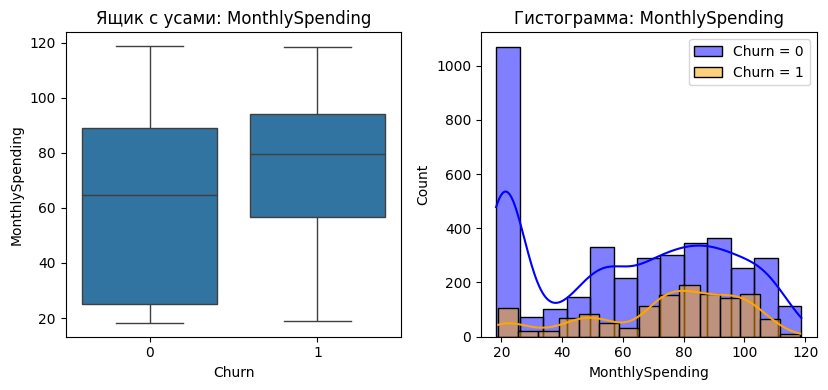

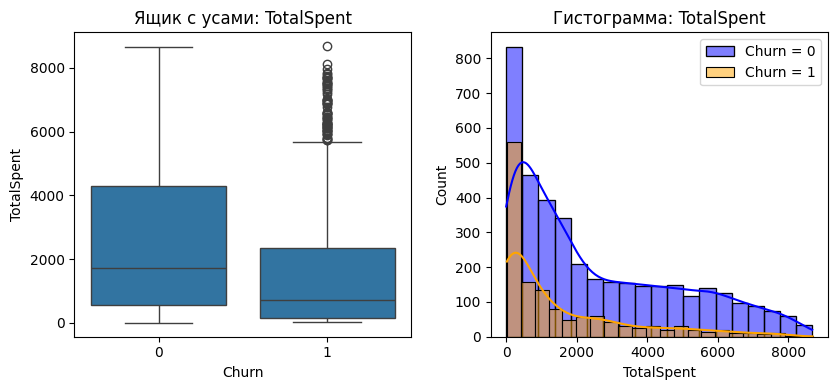

In [15]:
for feature in numeric_columns:
    plt.figure(figsize=(12, 4))

    # Ящик с усами
    plt.subplot(1, 3, 2)
    sns.boxplot(x='Churn', y=feature, data=data)
    plt.title(f'Ящик с усами: {feature}')

    # Гистограмма
    plt.subplot(1, 3, 3)
    sns.histplot(data[data['Churn'] == 0][feature], kde=True, color='blue', label='Churn = 0')
    sns.histplot(data[data['Churn'] == 1][feature], kde=True, color='orange', label='Churn = 1')
    plt.title(f'Гистограмма: {feature}')
    plt.legend()

    plt.tight_layout()
    plt.show()

Мы видим, что вероятнее уйдет клиент, недолго пользовавшийся услугами компании, но при этом тратящий в месяц больше.

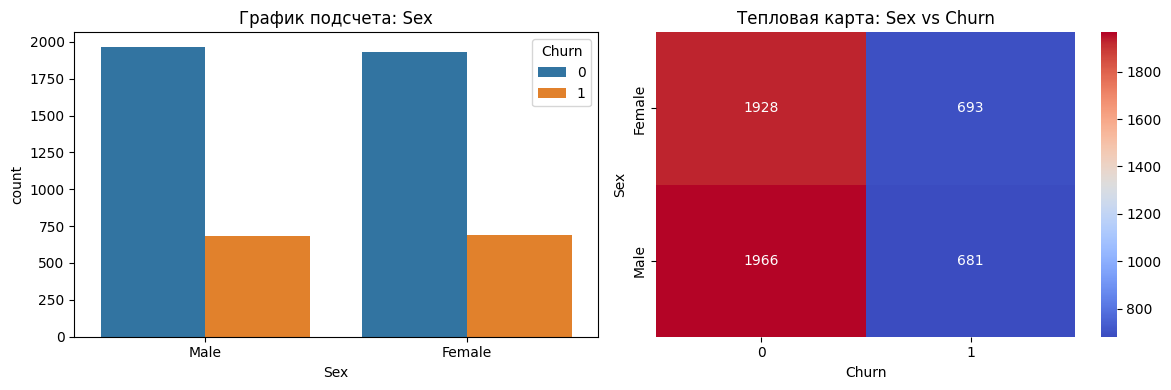

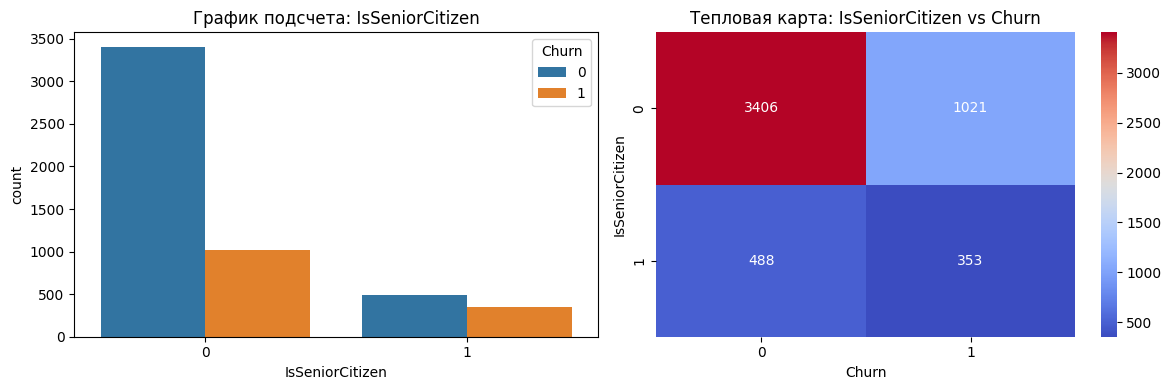

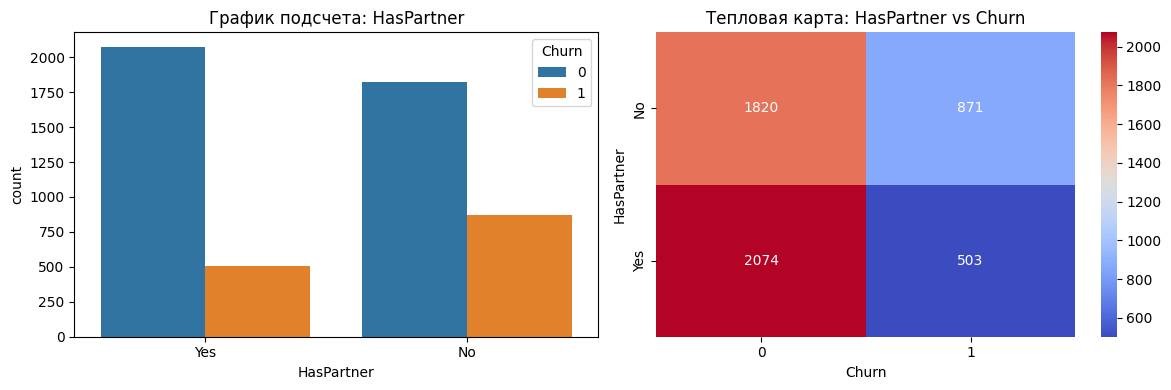

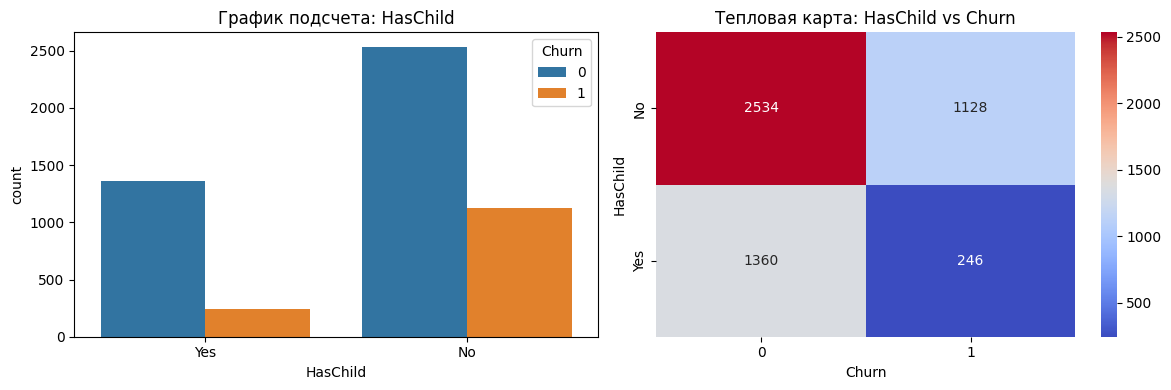

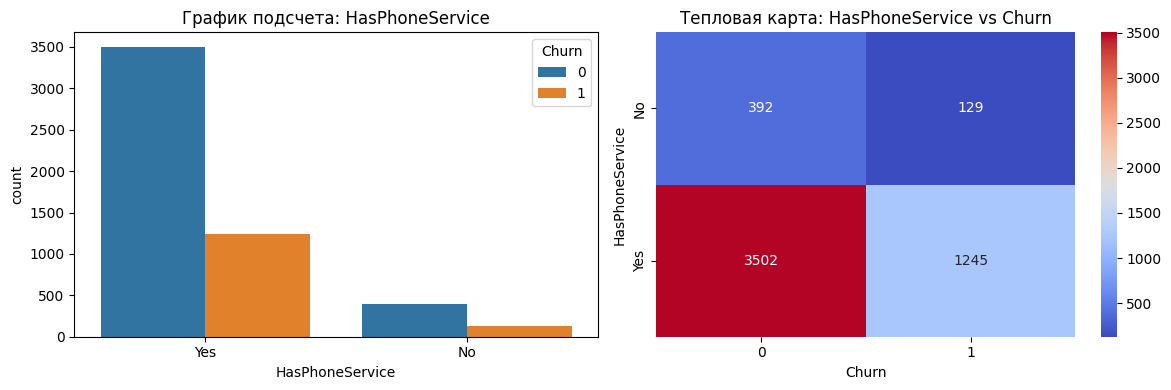

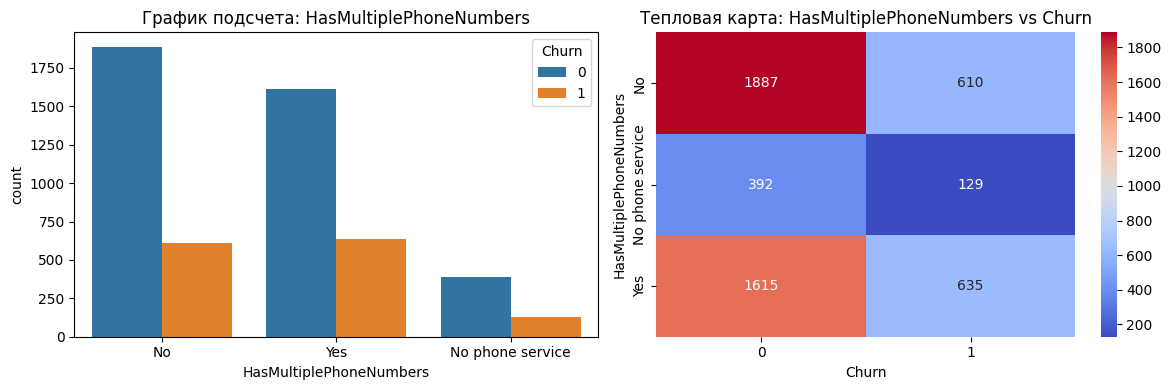

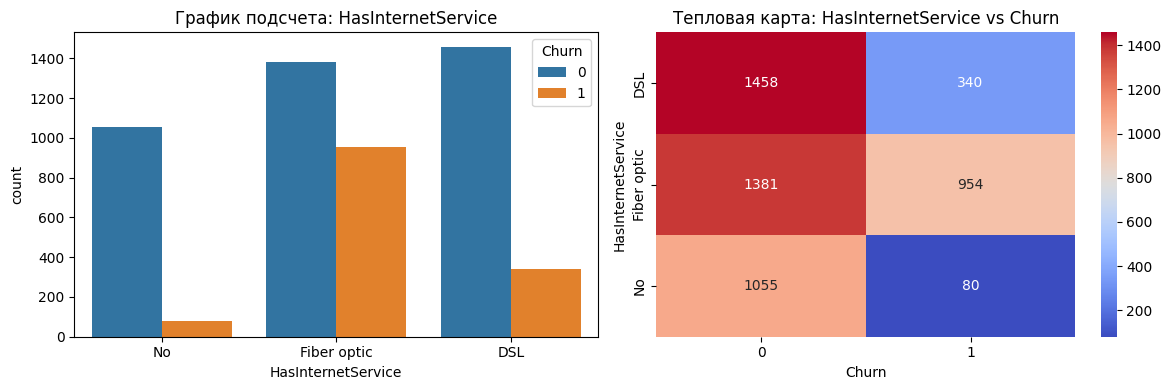

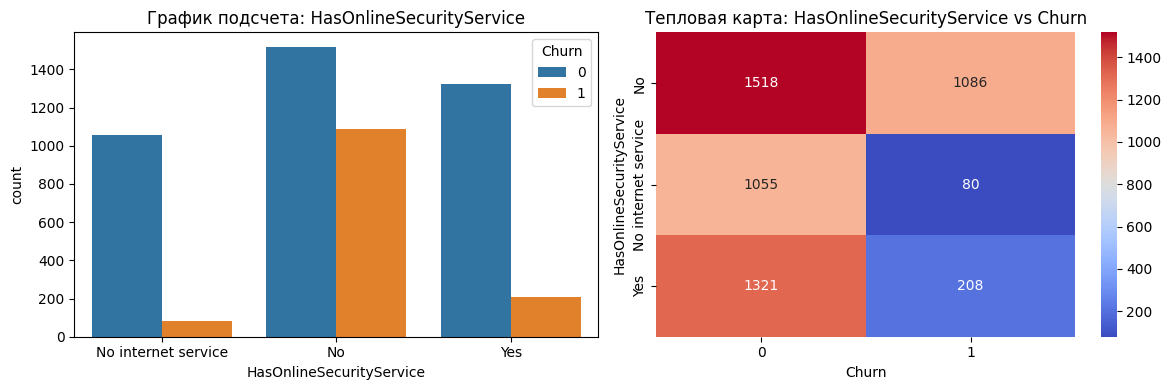

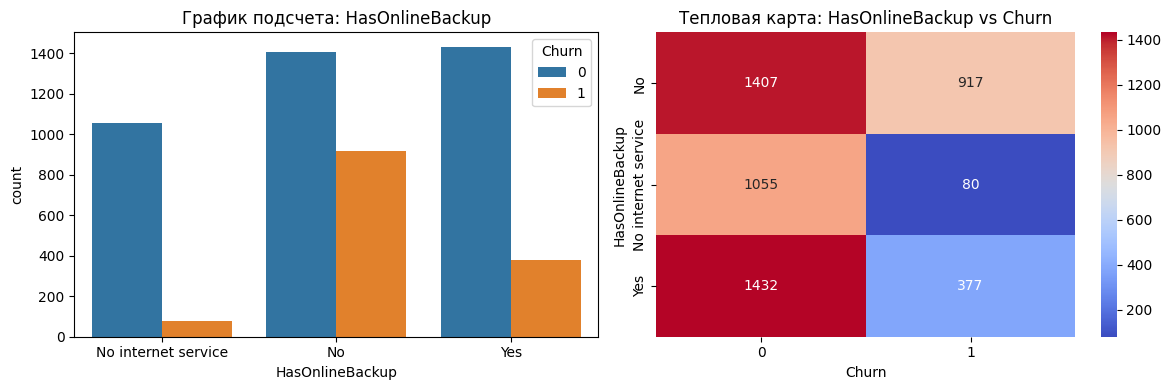

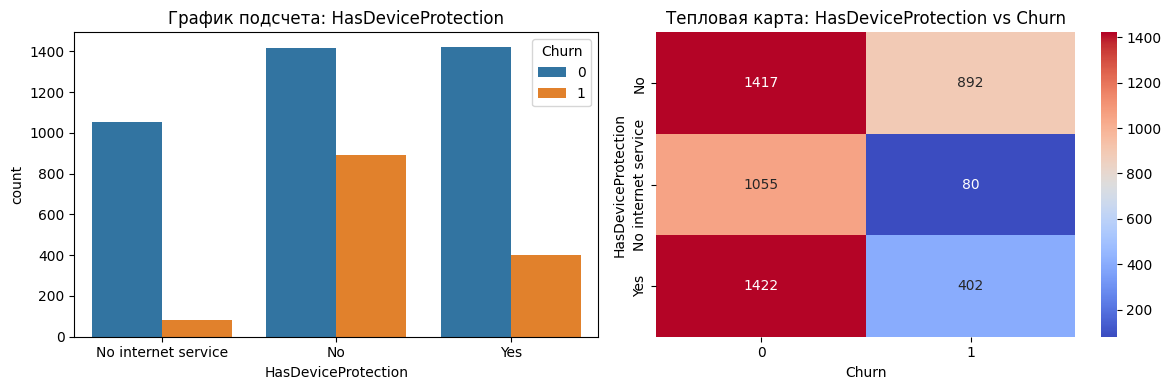

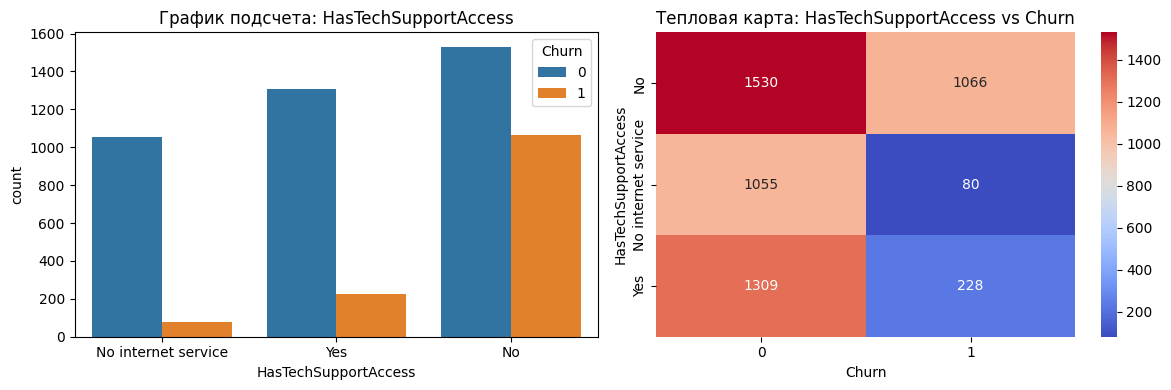

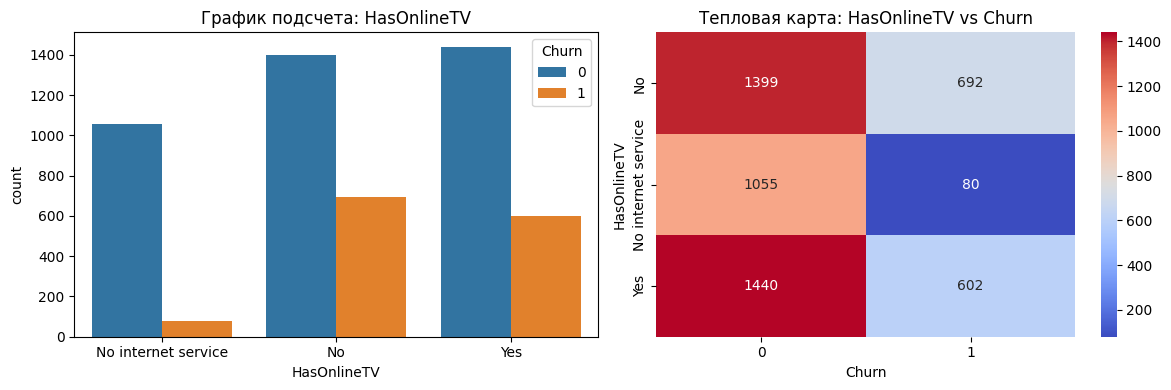

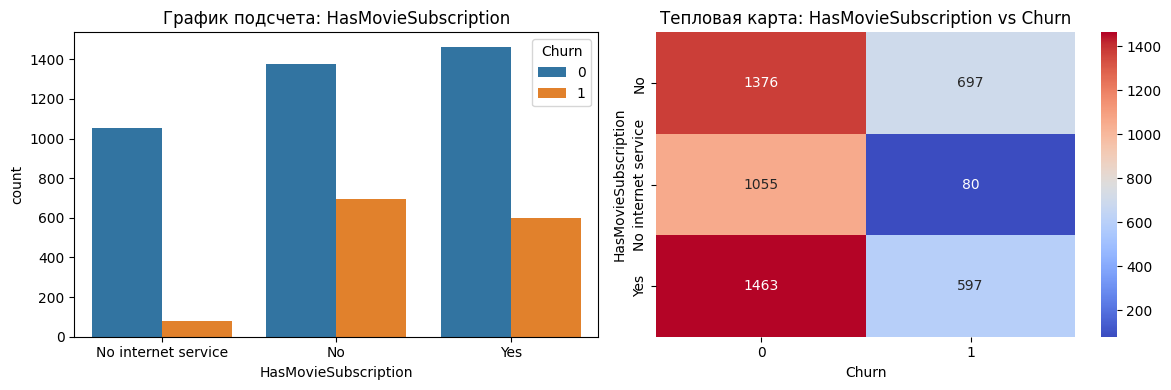

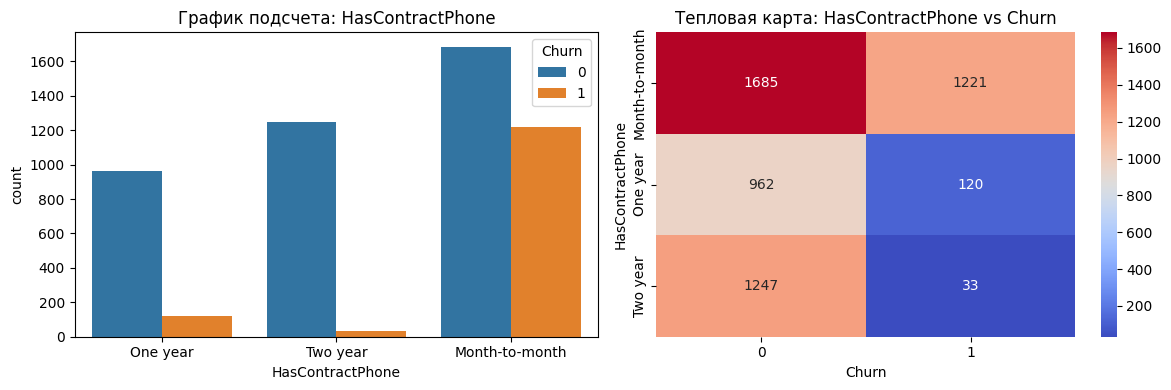

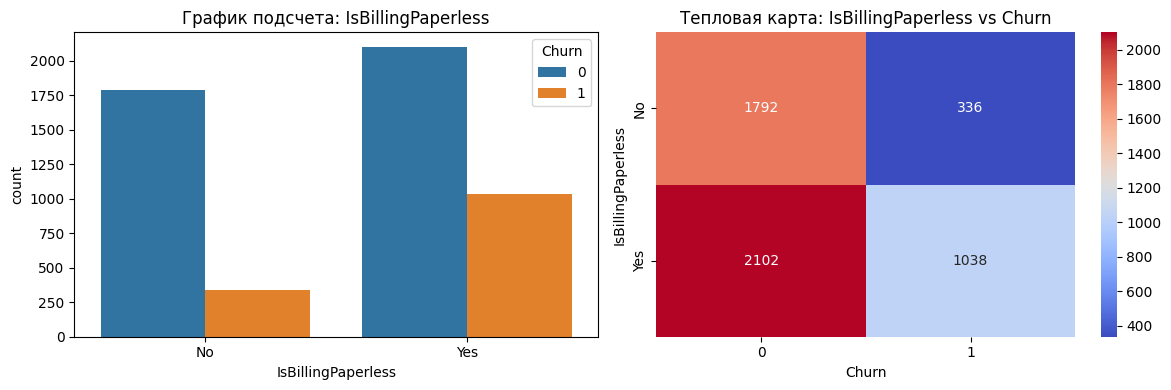

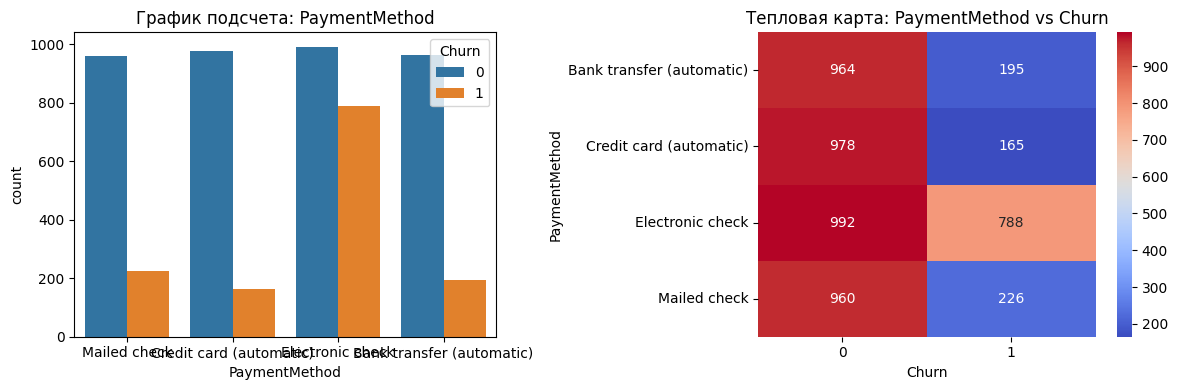

In [16]:
for feature in categorical_columns:
    plt.figure(figsize=(12, 4))

    # График подсчета
    plt.subplot(1, 2, 1)
    sns.countplot(x=feature, hue='Churn', data=data)
    plt.title(f'График подсчета: {feature}')

    # Тепловая карта
    plt.subplot(1, 2, 2)
    contingency_table = pd.crosstab(data[feature], data['Churn'])
    sns.heatmap(contingency_table, annot=True, cmap='coolwarm', fmt='d')
    plt.title(f'Тепловая карта: {feature} vs Churn')

    plt.tight_layout()
    plt.show()

Чаще всего клиенты либо уходят почти сразу, либо остаются надолго. Чем дольше они используют услуги, тем реже уходят.  
Люди, пользующиеся дополнительными услугами, более лояльны.  
Люди без партнера и детей уходят немного чаще.

In [17]:
for feature in numeric_columns:
    # Разделение данных по таргету
    group_0 = data[data['Churn'] == 0][feature]
    group_1 = data[data['Churn'] == 1][feature]

    # t-test
    t_stat, p_value = stats.ttest_ind(group_0, group_1)
    print(f"T-test для {feature}: t-статистика = {t_stat:.3f}, p-значение = {p_value:.6f}")

print(' ')

for feature in categorical_columns:
    # Таблица сопряженности
    contingency_table = pd.crosstab(data[feature], data['Churn'])

    # χ² тест
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    print(f"χ² тест для {feature}: χ² = {chi2:.3f}, p-значение = {p_value:.6f}")

T-test для ClientPeriod: t-статистика = 27.015, p-значение = 0.000000
T-test для MonthlySpending: t-статистика = -13.731, p-значение = 0.000000
T-test для TotalSpent: t-статистика = 14.671, p-значение = 0.000000
 
χ² тест для Sex: χ² = 0.311, p-значение = 0.576874
χ² тест для IsSeniorCitizen: χ² = 130.117, p-значение = 0.000000
χ² тест для HasPartner: χ² = 112.050, p-значение = 0.000000
χ² тест для HasChild: χ² = 138.054, p-значение = 0.000000
χ² тест для HasPhoneService: χ² = 0.451, p-значение = 0.501984
χ² тест для HasMultiplePhoneNumbers: χ² = 9.356, p-значение = 0.009300
χ² тест для HasInternetService: χ² = 525.626, p-значение = 0.000000
χ² тест для HasOnlineSecurityService: χ² = 666.439, p-значение = 0.000000
χ² тест для HasOnlineBackup: χ² = 454.726, p-значение = 0.000000
χ² тест для HasDeviceProtection: χ² = 417.355, p-значение = 0.000000
χ² тест для HasTechSupportAccess: χ² = 616.346, p-значение = 0.000000
χ² тест для HasOnlineTV: χ² = 278.843, p-значение = 0.000000
χ² тест для

Мы видим, что, вероятно, не имеют влияния на целевую переменную пол и наличие телефона.  
Исключим эти признаки.

In [18]:
data = data.drop(['TotalSpent', 'Sex', 'HasPhoneService'], axis=1)

### Переходим к построению моделей

In [19]:
X = data.drop('Churn', axis=1)
y = data['Churn']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

#### Логистическая регрессия

Сначала построим простую логистическую регрессию, предварительно стандартизировав числовые признаки и закодировав категориальные при помощи one-hot-encoding'а. Подберем оптимальное значение C на кросс-валидации.

In [20]:
numeric_columns = ['ClientPeriod', 'MonthlySpending']
categorical_columns = ['IsSeniorCitizen', 'HasPartner', 'HasChild', 'HasMultiplePhoneNumbers', 'HasInternetService', 
                        'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection', 'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription', 
                        'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

Лучшее значение C: 100
Лучшее значение ROC-AUC: 0.8426467322810962


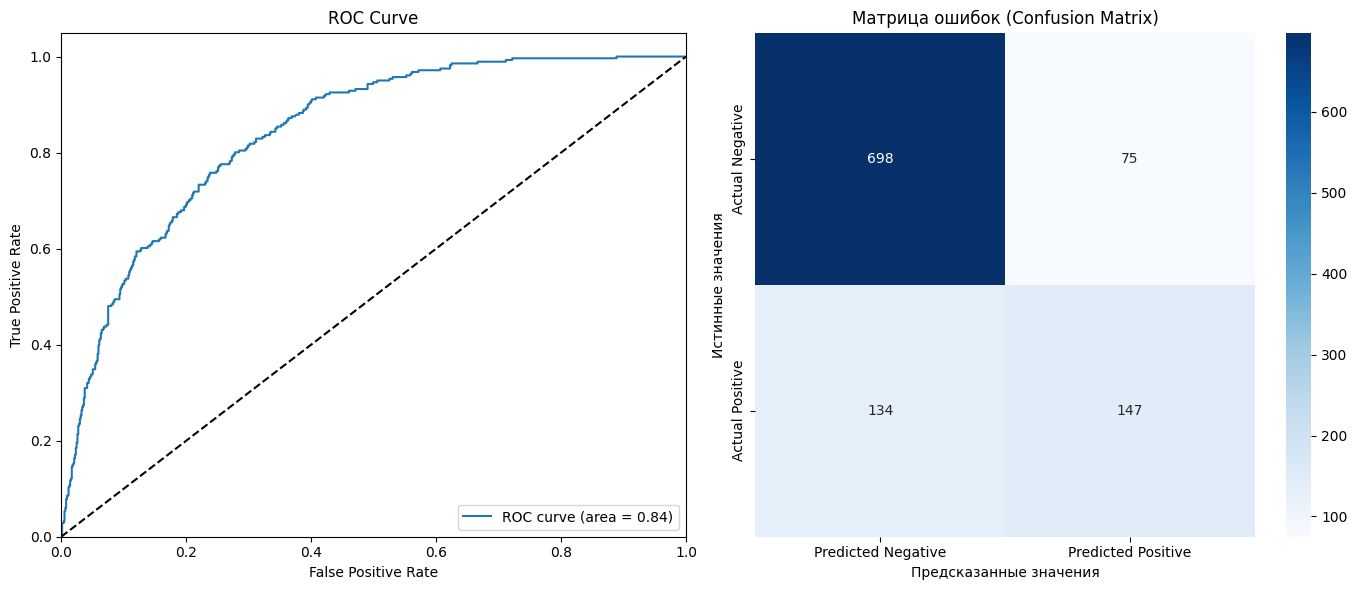

In [21]:
param_grid = {
    'classifier__C': [100, 10, 1, 0.1, 0.01, 0.001]
}

roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=roc_auc_scorer)
grid_search.fit(X_train, y_train)

best_c = grid_search.best_params_['classifier__C']
best_roc_auc = grid_search.best_score_

print(f"Лучшее значение C: {best_c}")
print(f"Лучшее значение ROC-AUC: {best_roc_auc}")

# Обучение модели с лучшими параметрами
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_valid)
y_pred_proba = best_model.predict_proba(X_valid)[:, 1]

# Вычисление метрик
roc_auc = roc_auc_score(y_valid, y_pred_proba)
conf_matrix = confusion_matrix(y_valid, y_pred)

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC кривая
fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
axes[0].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc="lower right")

# Матрица ошибок
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[1],
             xticklabels=['Predicted Negative', 'Predicted Positive'],
             yticklabels=['Actual Negative', 'Actual Positive'])
axes[1].set_title('Матрица ошибок (Confusion Matrix)')
axes[1].set_xlabel('Предсказанные значения')
axes[1].set_ylabel('Истинные значения')

plt.tight_layout()
plt.show()

In [22]:
# Расчет recall
recall = recall_score(y_valid, y_pred)
print(f"Recall: {recall:.2f}")

Recall: 0.52


Лучшее значение C: 100  
ROC-AUC: 0.8426  
Recall: 0.52  
Неплохой результат, но слишком много уходящих клиентов остались незамеченными.

#### Случайный лес.

Стандартные гиперпараметры.

ROC-AUC: 0.8008015174045753


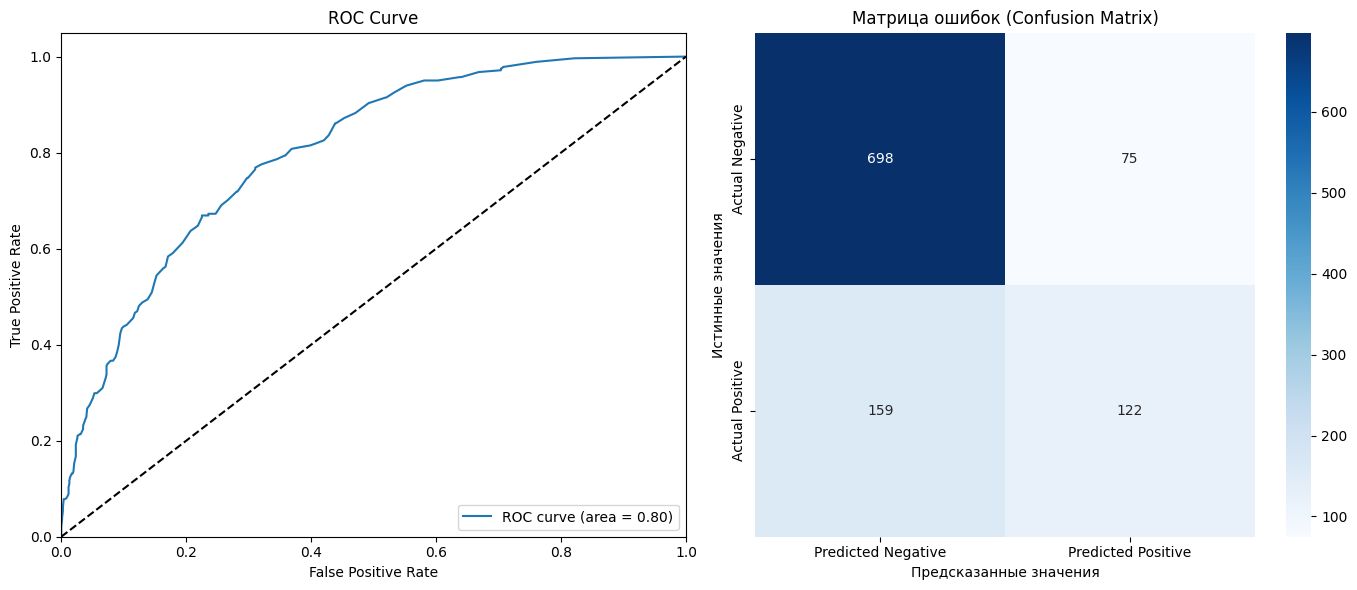

In [23]:
# пайплайн
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_columns),  # Числовые признаки остаются без изменений, т к случайный лес не требует нормализации
        ('cat', OneHotEncoder(), categorical_columns)
    ])

# Создание полного пайплайна с Random Forest
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_valid)
y_pred_proba = pipeline.predict_proba(X_valid)[:, 1]

# Вычисление метрик
roc_auc = roc_auc_score(y_valid, y_pred_proba)
conf_matrix = confusion_matrix(y_valid, y_pred)

print(f"ROC-AUC: {roc_auc}")

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC кривая
fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
axes[0].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc="lower right")

# Матрица ошибок
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[1],
             xticklabels=['Predicted Negative', 'Predicted Positive'],
             yticklabels=['Actual Negative', 'Actual Positive'])
axes[1].set_title('Матрица ошибок (Confusion Matrix)')
axes[1].set_xlabel('Предсказанные значения')
axes[1].set_ylabel('Истинные значения')

plt.tight_layout()
plt.show()

In [24]:
# Расчет recall
recall = recall_score(y_valid, y_pred)
print(f"Recall: {recall:.2f}")

Recall: 0.43


Подберем гиперпараметры на кросс-валидации.

Лучшие параметры: {'classifier__bootstrap': True, 'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Лучшее значение ROC-AUC: 0.8426467322810962


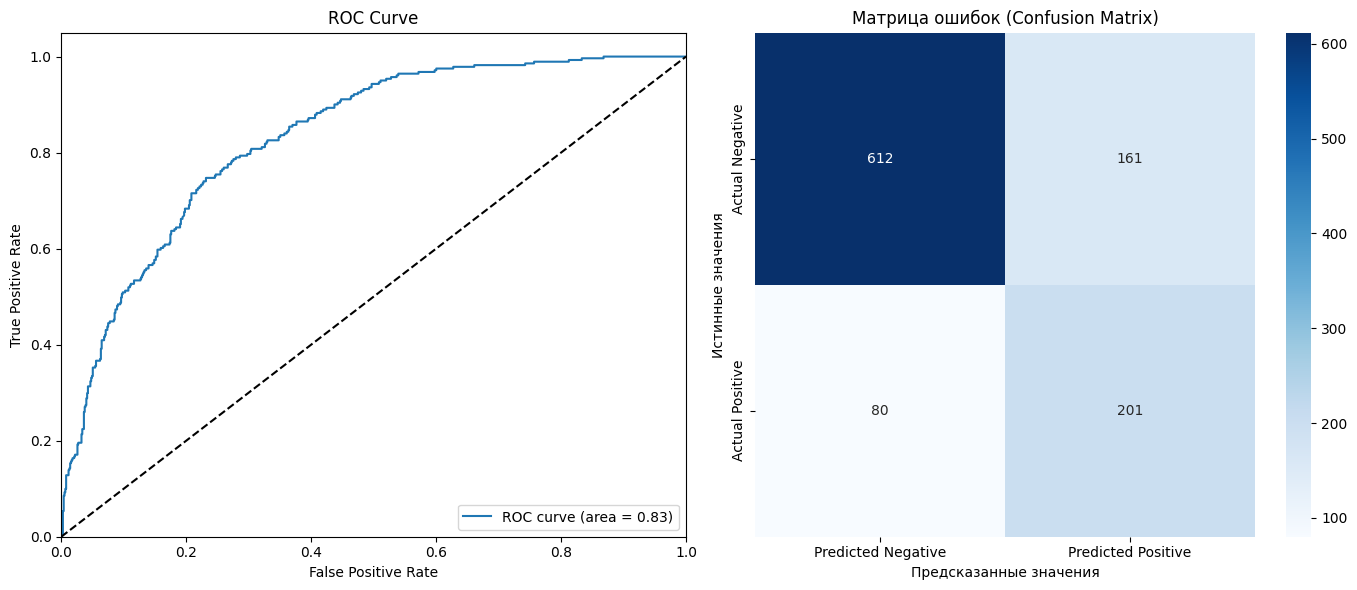

In [25]:
# параметры для поиска
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False],
    'classifier__class_weight': ['balanced', 'balanced_subsample']
}
# Подбор гиперпараметров
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=roc_auc_scorer)
grid_search.fit(X_train, y_train)

# Лучшие параметры
best_params = grid_search.best_params_
print(f"Лучшие параметры: {best_params}")

# Обучение модели с лучшими параметрами
best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_valid)
y_pred_proba = best_pipeline.predict_proba(X_valid)[:, 1]

# Вычисление метрик
roc_auc = roc_auc_score(y_valid, y_pred_proba)
conf_matrix = confusion_matrix(y_valid, y_pred)

print(f"Лучшее значение ROC-AUC: {best_roc_auc}")

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC кривая
fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
axes[0].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc="lower right")

# Матрица ошибок
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[1],
             xticklabels=['Predicted Negative', 'Predicted Positive'],
             yticklabels=['Actual Negative', 'Actual Positive'])
axes[1].set_title('Матрица ошибок (Confusion Matrix)')
axes[1].set_xlabel('Предсказанные значения')
axes[1].set_ylabel('Истинные значения')

plt.tight_layout()
plt.show()

In [26]:
# Расчет recall
recall = recall_score(y_valid, y_pred)
print(f"Recall: {recall:.2f}")

Recall: 0.72


Случайный лес с гиперпараметрами:  
- 'classifier__bootstrap': True, 
- 'classifier__class_weight': 'balanced', 
- 'classifier__max_depth': 10, 
- 'classifier__min_samples_leaf': 4, 
- 'classifier__min_samples_split': 10, 
- 'classifier__n_estimators': 200.  

ROC-AUC: 0.808  
Recall: 0.69  
Случайный лес немного лучше определяет 1й класс.

#### Catboost

Теперь попробуем catboost со стандартными гиперпараметрами. Не забудем сбалансировать классы.

ROC-AUC со стандартными параметрами: 0.8392522546993044


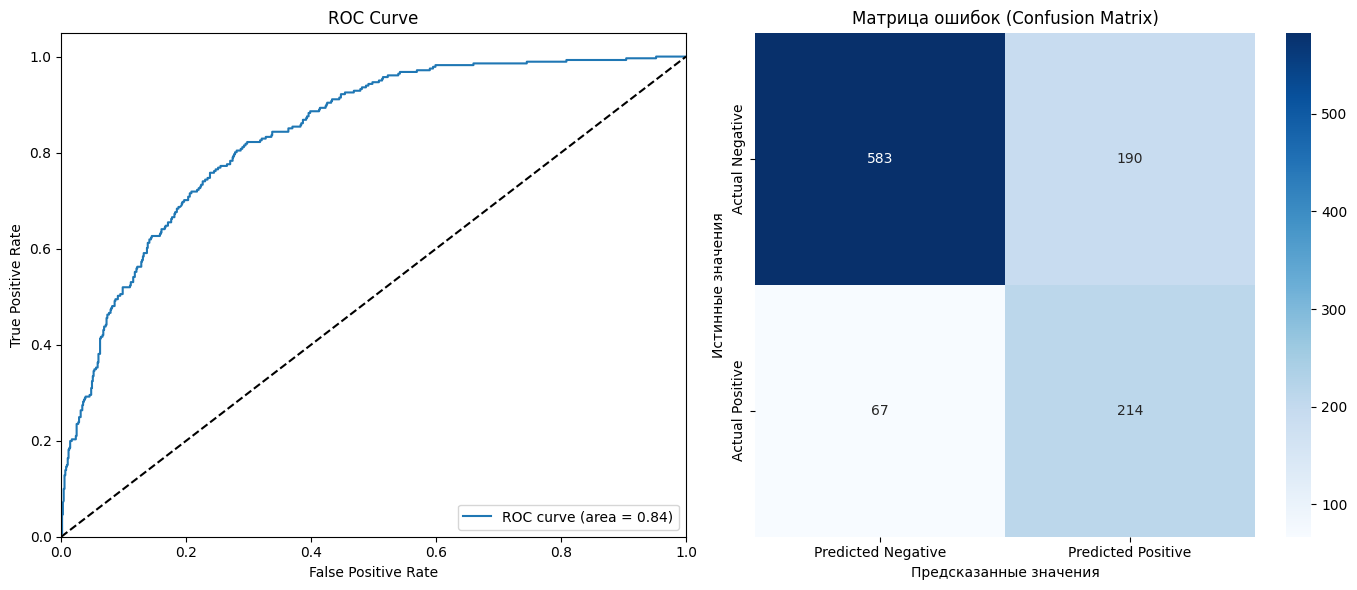

In [27]:
categorical_indices = [X.columns.get_loc(col) for col in categorical_columns]

model = CatBoostClassifier(verbose=0, cat_features=categorical_indices, auto_class_weights='Balanced', random_state=42)

model.fit(
    X_train, y_train,
    verbose=0
)

y_valid_pred = model.predict_proba(X_valid)[:, 1]

roc_auc_simple_catboost = roc_auc_score(y_valid, y_valid_pred)
print(f"ROC-AUC со стандартными параметрами: {roc_auc_simple_catboost}")

y_pred = model.predict(X_valid)
y_pred_proba = model.predict_proba(X_valid)[:, 1]

# Вычисление метрик
roc_auc = roc_auc_score(y_valid, y_pred_proba)
conf_matrix = confusion_matrix(y_valid, y_pred)

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC кривая
fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
axes[0].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc="lower right")

# Матрица ошибок
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[1],
             xticklabels=['Predicted Negative', 'Predicted Positive'],
             yticklabels=['Actual Negative', 'Actual Positive'])
axes[1].set_title('Матрица ошибок (Confusion Matrix)')
axes[1].set_xlabel('Предсказанные значения')
axes[1].set_ylabel('Истинные значения')

plt.tight_layout()
plt.show()

In [28]:
# Расчет recall
recall = recall_score(y_valid, y_pred)
print(f"Recall: {recall:.2f}")

Recall: 0.76


Кросс-валидация:

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Лучшие параметры: {'depth': 4, 'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.1, 'scale_pos_weight': 2}
Лучший ROC-AUC score: 0.8471


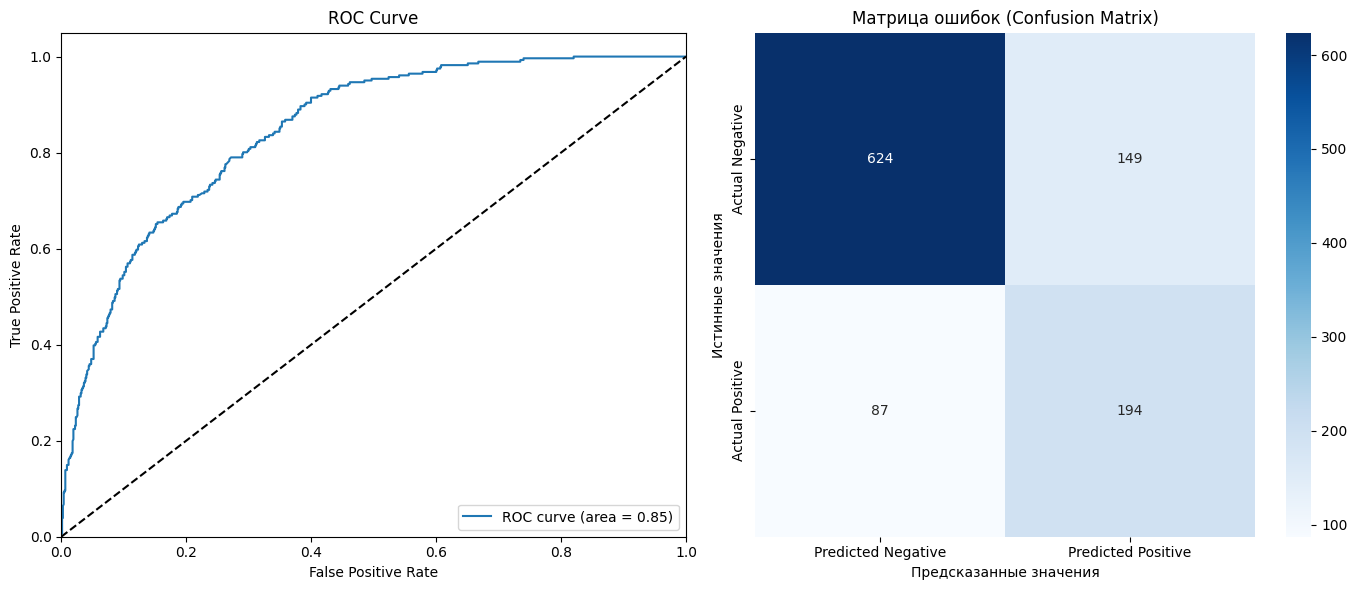

In [29]:
model = CatBoostClassifier(
    verbose=0,
    cat_features=categorical_indices,
    eval_metric='AUC',
    random_seed=42
)

param_grid = {
    'iterations': [100, 200],
    'learning_rate': [0.05, 0.1],
    'depth': [4, 6],
    'l2_leaf_reg': [1, 3, 5],
    'scale_pos_weight': [1, 2, 5],
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=roc_auc_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший ROC-AUC score: {grid_search.best_score_:.4f}")

best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_valid)
y_pred_proba = best_pipeline.predict_proba(X_valid)[:, 1]

# Вычисление метрик
roc_auc = roc_auc_score(y_valid, y_pred_proba)
conf_matrix = confusion_matrix(y_valid, y_pred)

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC кривая
fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
axes[0].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc="lower right")

# Матрица ошибок
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[1],
             xticklabels=['Predicted Negative', 'Predicted Positive'],
             yticklabels=['Actual Negative', 'Actual Positive'])
axes[1].set_title('Матрица ошибок (Confusion Matrix)')
axes[1].set_xlabel('Предсказанные значения')
axes[1].set_ylabel('Истинные значения')

plt.tight_layout()
plt.show()

In [30]:
# Расчет recall
recall = recall_score(y_valid, y_pred)
print(f"Recall: {recall:.2f}")

Recall: 0.69


Катбуст со стандартными гиперпараметрами:  
ROC-AUC: 0.823  
Recall: 0.72  

Катбуст с гиперпараметрами:  
- 'depth': 4, 
- 'iterations': 200, 
- 'l2_leaf_reg': 5, 
- 'learning_rate': 0.05, 
- 'scale_pos_weight': 2.

ROC-AUC: 0.8516  
Recall: 0.68  

На подобранных гиперпараметрах мы получили ROC-AUC лучше, но recall лучше при стандартных гиперпараметрах и автоматически сбалансированных классах.

#### XGBoost.

d:\IT\pytony-gaduki\kaggle_user_churn\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [11:40:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


ROC-AUC: 0.8148660531367828


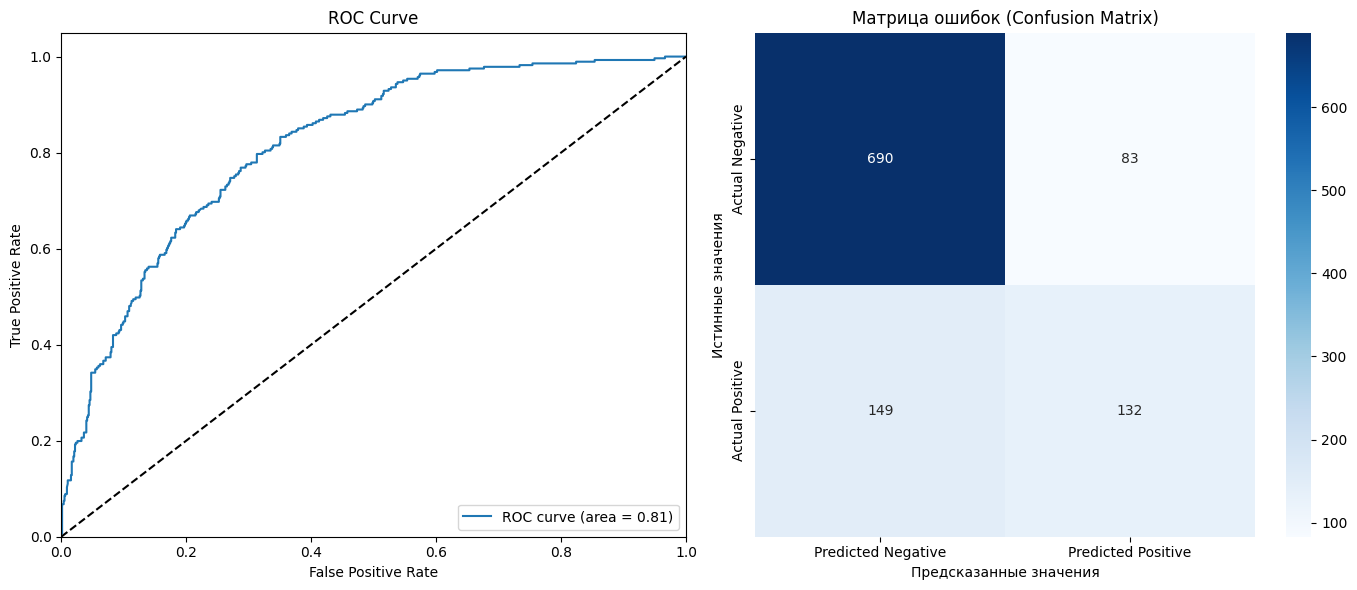

In [31]:
# Создание преобразователя для категориальных и числовых признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])

# Создание конвейера с XGBoost
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='auc'))
])

# Обучение модели
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_valid)
y_pred_proba = pipeline.predict_proba(X_valid)[:, 1]

# Вычисление метрик
roc_auc = roc_auc_score(y_valid, y_pred_proba)
conf_matrix = confusion_matrix(y_valid, y_pred)

print(f"ROC-AUC: {roc_auc}")

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC кривая
fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
axes[0].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc="lower right")

# Матрица ошибок
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[1],
             xticklabels=['Predicted Negative', 'Predicted Positive'],
             yticklabels=['Actual Negative', 'Actual Positive'])
axes[1].set_title('Матрица ошибок (Confusion Matrix)')
axes[1].set_xlabel('Предсказанные значения')
axes[1].set_ylabel('Истинные значения')

plt.tight_layout()
plt.show()

In [32]:
# Расчет recall
recall = recall_score(y_valid, y_pred)
print(f"Recall: {recall:.2f}")

Recall: 0.47


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


d:\IT\pytony-gaduki\kaggle_user_churn\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [11:42:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Лучшие параметры: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__reg_alpha': 0.5, 'classifier__reg_lambda': 1.5, 'classifier__scale_pos_weight': 1}
Лучший ROC-AUC score: 0.8445


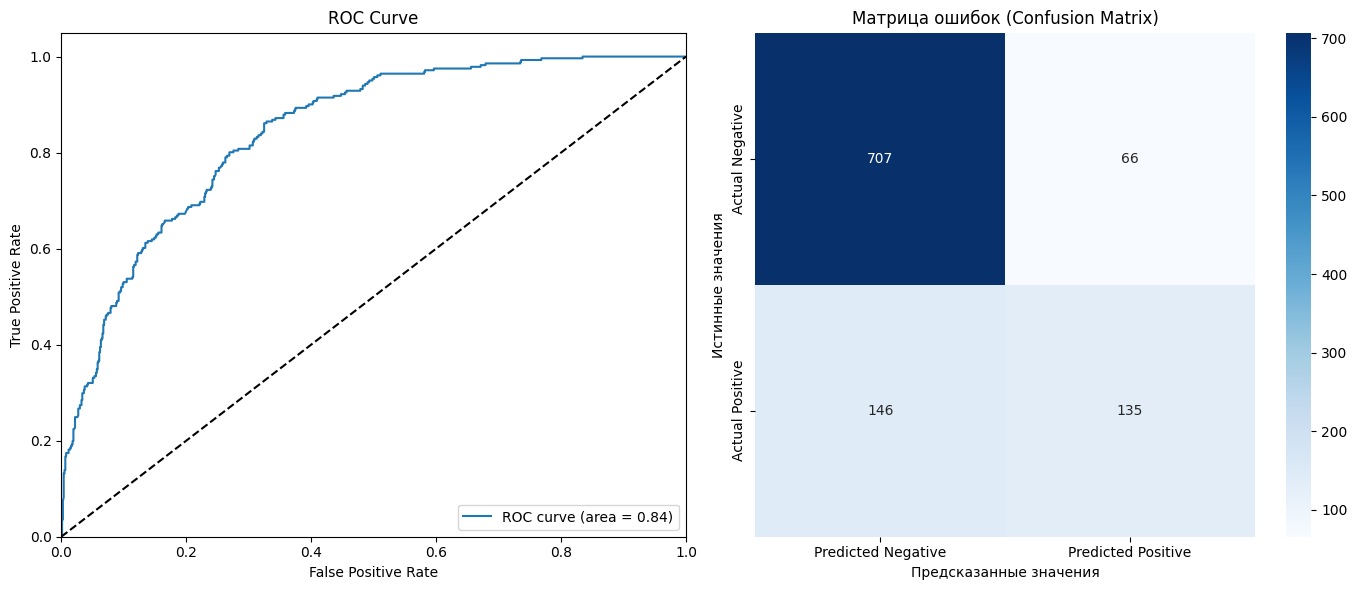

In [33]:
# Параметры для Grid Search
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [3, 6, 9],
    'classifier__scale_pos_weight': [1, 2, 3, 5],  # Перевзвешивание положительного класса
    'classifier__reg_alpha': [0, 0.1, 0.5],
    'classifier__reg_lambda': [1, 1.5, 2]
}

# Настройка Grid Search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=roc_auc_scorer,
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Запуск Grid Search
grid_search.fit(X_train, y_train)

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший ROC-AUC score: {grid_search.best_score_:.4f}")

best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_valid)
y_pred_proba = best_pipeline.predict_proba(X_valid)[:, 1]

# Вычисление метрик
roc_auc = roc_auc_score(y_valid, y_pred_proba)
conf_matrix = confusion_matrix(y_valid, y_pred)

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC кривая
fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
axes[0].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc="lower right")

# Матрица ошибок
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[1],
             xticklabels=['Predicted Negative', 'Predicted Positive'],
             yticklabels=['Actual Negative', 'Actual Positive'])
axes[1].set_title('Матрица ошибок (Confusion Matrix)')
axes[1].set_xlabel('Предсказанные значения')
axes[1].set_ylabel('Истинные значения')

plt.tight_layout()
plt.show()

In [34]:
# Расчет recall
recall = recall_score(y_valid, y_pred)
print(f"Recall: {recall:.2f}")

Recall: 0.48


XGBoost, что со стандартными гиперпараметрами и сбалансированными классами, что с подобранными:  
- 'classifier__learning_rate': 0.01, 
- 'classifier__max_depth': 3, 
- 'classifier__n_estimators': 200, 
- 'classifier__reg_alpha': 0.1, 
- 'classifier__reg_lambda': 1.5, 
- 'classifier__scale_pos_weight': 1.

Выдал ROC-AUC чуть меньше, чем катбуст, но recall получился очень низкий. Модель плохо предсказывает 1й класс, который нам так важен.  

### Оверсамплинг

Модель Catboost показала лучшие результаты ROC-AUC и, что самое важное, лучший recall, поэтому мы будем использовать её.  
Начнем со SMOTE.

In [35]:
# Создание преобразователя для категориальных и числовых признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])

# Применение преобразователя к данным
X_transformed = preprocessor.fit_transform(X)

# Разделение данных на обучающую и тестовую выборки
X_train, X_valid, y_train, y_valid = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [36]:
# Применение SMOTE для увеличения выборки
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

d:\IT\pytony-gaduki\kaggle_user_churn\.venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Не удается найти указанный файл
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\IT\pytony-gaduki\kaggle_user_churn\.venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\yaroslave\AppData\Local\Programs\Python\Python38\lib\subprocess.py", line 489, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\yaroslave\AppData\Local\Programs\Python\Python38\lib\subprocess.py", line 854, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\yaroslave\AppData\Local\Programs\Python\Python38\lib\subprocess.py", line 1307, 

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Лучшие параметры: {'depth': 6, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'scale_pos_weight': 1}
Лучший ROC-AUC score: 0.9342


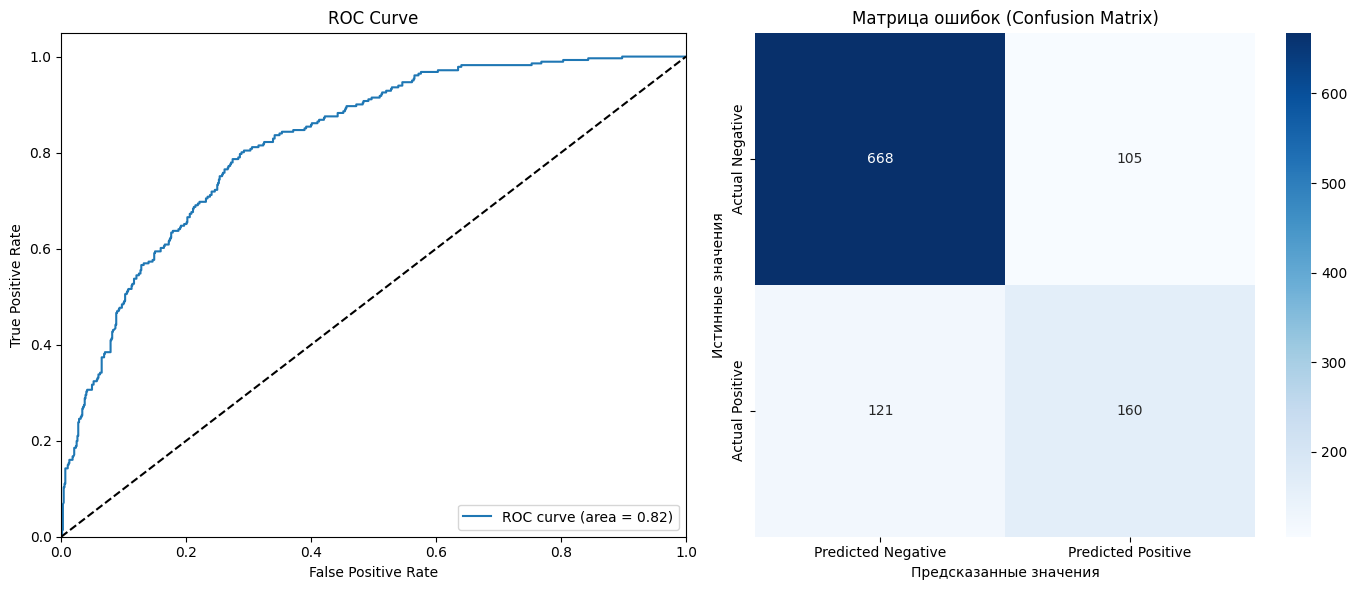

In [37]:
model = CatBoostClassifier(
    verbose=0,
    eval_metric='AUC',
    random_seed=42
)
param_grid = {
    'iterations': [100, 200],
    'learning_rate': [0.05, 0.1],
    'depth': [4, 6],
    'l2_leaf_reg': [1, 3, 5],
    'scale_pos_weight': [1, 2, 5],
}
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=roc_auc_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_resampled, y_resampled)
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший ROC-AUC score: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_valid)
y_pred_proba = best_model.predict_proba(X_valid)[:, 1]

# Вычисление метрик
roc_auc = roc_auc_score(y_valid, y_pred_proba)
conf_matrix = confusion_matrix(y_valid, y_pred)

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC кривая
fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
axes[0].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc="lower right")

# Матрица ошибок
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[1],
             xticklabels=['Predicted Negative', 'Predicted Positive'],
             yticklabels=['Actual Negative', 'Actual Positive'])
axes[1].set_title('Матрица ошибок (Confusion Matrix)')
axes[1].set_xlabel('Предсказанные значения')
axes[1].set_ylabel('Истинные значения')

plt.tight_layout()
plt.show()

In [38]:
# Расчет recall
recall = recall_score(y_valid, y_pred)
print(f"Recall: {recall:.2f}")

Recall: 0.57


Мы получили очень хороший ROC-AUC, но слишком низкий recall.  
'depth': 6, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'scale_pos_weight': 1  
ROC-AUC score: 0.9357  
Recall: 0.57

In [39]:
# Применение SMOTE + Tomek Links
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Лучшие параметры: {'depth': 6, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'scale_pos_weight': 1}
Лучший ROC-AUC score: 0.9447


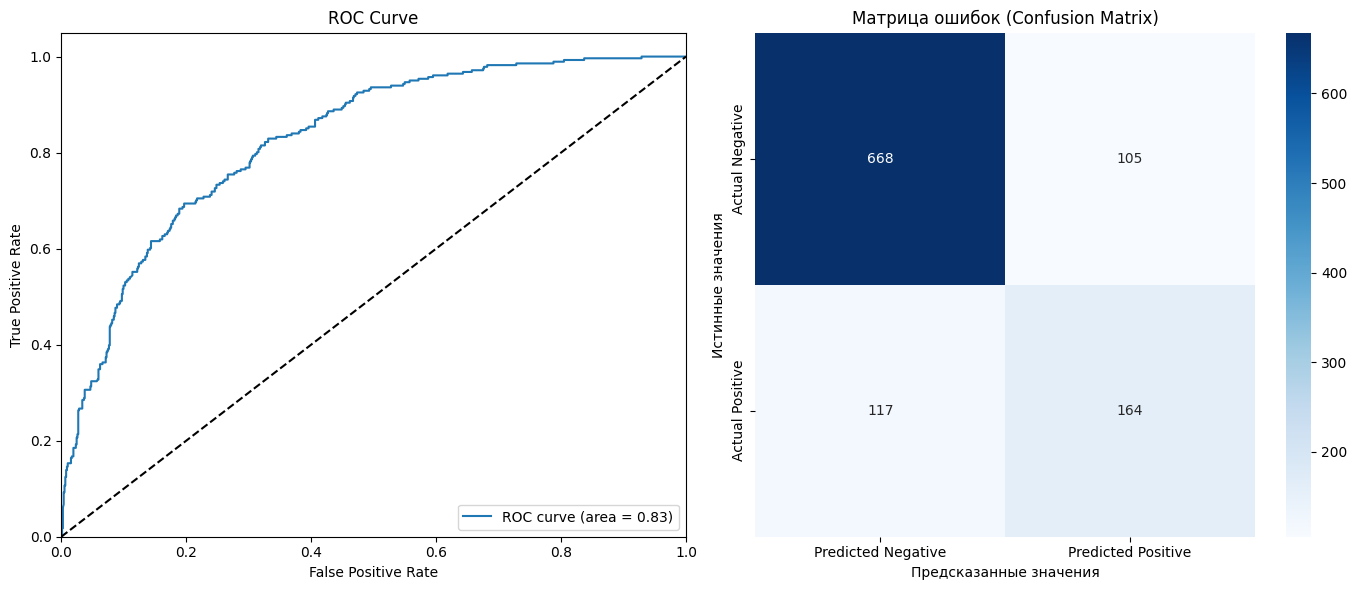

In [40]:
model = CatBoostClassifier(
    verbose=0,
    eval_metric='AUC',
    random_seed=42
)
param_grid = {
    'iterations': [100, 200],
    'learning_rate': [0.05, 0.1],
    'depth': [4, 6],
    'l2_leaf_reg': [1, 3, 5],
    'scale_pos_weight': [1, 2, 5],
}
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=roc_auc_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_resampled, y_resampled)
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший ROC-AUC score: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_valid)
y_pred_proba = best_model.predict_proba(X_valid)[:, 1]

# Вычисление метрик
roc_auc = roc_auc_score(y_valid, y_pred_proba)
conf_matrix = confusion_matrix(y_valid, y_pred)

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC кривая
fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
axes[0].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc="lower right")

# Матрица ошибок
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[1],
             xticklabels=['Predicted Negative', 'Predicted Positive'],
             yticklabels=['Actual Negative', 'Actual Positive'])
axes[1].set_title('Матрица ошибок (Confusion Matrix)')
axes[1].set_xlabel('Предсказанные значения')
axes[1].set_ylabel('Истинные значения')

plt.tight_layout()
plt.show()

In [41]:
# Расчет recall
recall = recall_score(y_valid, y_pred)
print(f"Recall: {recall:.2f}")

Recall: 0.58


Благодаря Tomek мы улучшили результат, но модель все еще плохо справляется с минорным классом.  
'depth': 6, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'scale_pos_weight': 1  
ROC-AUC score: 0.9505  
Recall: 0.58

Несмотря на оверсамплинг модель все еще плохо предсказывает нужный нам 1й класс. Поэтому, несмотря на то, что в соревновании важно оптимизировать ROC-AUC, мы попробуем оптимизировать Recall вместо него.

In [42]:
# Определение метрики оценки
recall_scorer = make_scorer(recall_score, pos_label=1)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Лучшие параметры: {'depth': 6, 'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.05, 'scale_pos_weight': 5}
Лучший ROC-AUC score: 0.9746


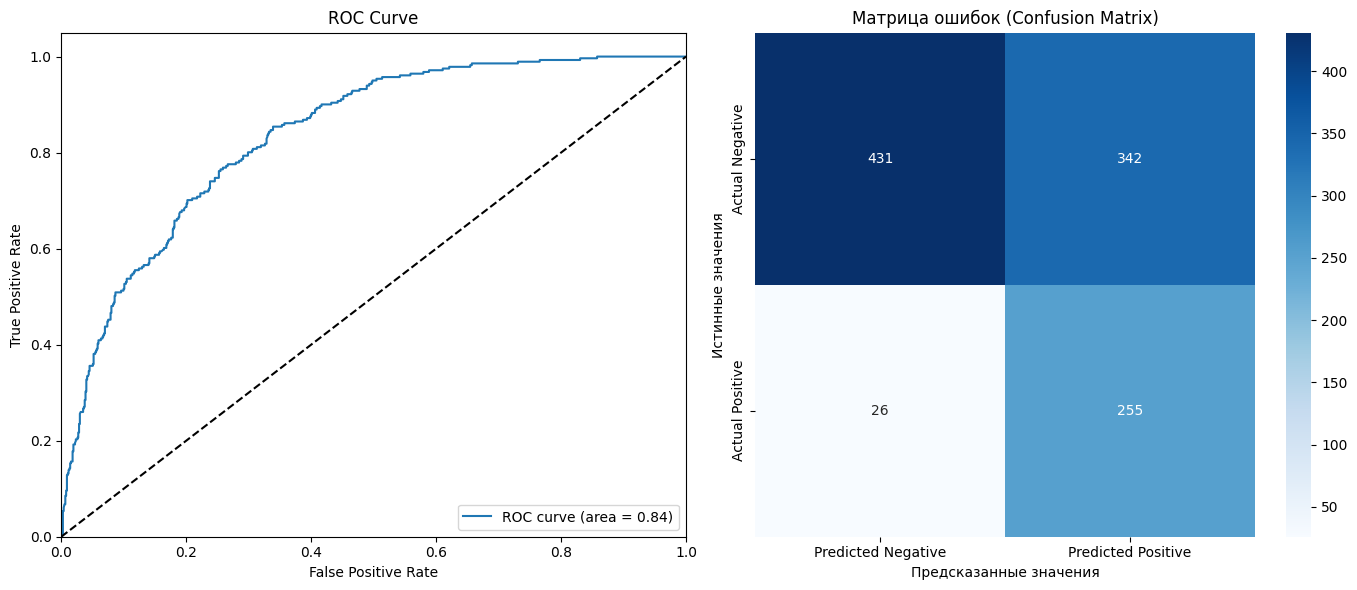

In [43]:
model = CatBoostClassifier(
    verbose=0,
    eval_metric='AUC',
    random_seed=42
)
param_grid = {
    'iterations': [100, 200],
    'learning_rate': [0.05, 0.1],
    'depth': [4, 6],
    'l2_leaf_reg': [1, 3, 5],
    'scale_pos_weight': [1, 2, 5],
}
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=recall_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_resampled, y_resampled)
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший ROC-AUC score: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_valid)
y_pred_proba = best_model.predict_proba(X_valid)[:, 1]

# Вычисление метрик
roc_auc = roc_auc_score(y_valid, y_pred_proba)
conf_matrix = confusion_matrix(y_valid, y_pred)

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC кривая
fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
axes[0].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc="lower right")

# Матрица ошибок
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[1],
             xticklabels=['Predicted Negative', 'Predicted Positive'],
             yticklabels=['Actual Negative', 'Actual Positive'])
axes[1].set_title('Матрица ошибок (Confusion Matrix)')
axes[1].set_xlabel('Предсказанные значения')
axes[1].set_ylabel('Истинные значения')

plt.tight_layout()
plt.show()

In [44]:
# Расчет recall
recall = recall_score(y_valid, y_pred)
print(f"Recall: {recall:.2f}")

Recall: 0.91


Благодаря этому получилось сильно улучшить результат.  
'depth': 4, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.05, 'scale_pos_weight': 5  
ROC-AUC: 0.9758  
Recall: 0.94

Итоговый пайплайн выглядит так:
- исправили ошибочные типы данных в колонках, заполнили пропуски, удалили дубликаты, удалили фичи, скореллированные с другими, а также не оказывающие влияния на целевую переменную
- использовали StandardScaler для числовых колонок и one hot encoding для категориальных
- сделали оверсамплинг SMOTE + Tomek Links
- подобрали на грид серч кросс валидации гиперпараметры, ориентируясь на recall 
- 'depth': 4, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.05, 'scale_pos_weight': 5 
- получили на тесте ROC-AUC 0.9758 и recall 0.94

In [45]:
report = classification_report(y_valid, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.56      0.70       773
           1       0.43      0.91      0.58       281

    accuracy                           0.65      1054
   macro avg       0.69      0.73      0.64      1054
weighted avg       0.81      0.65      0.67      1054



Как мы видим, точность у модели страдает, но зато она замечает почти всех клиентов, которые скоро перестанут пользоваться услугами компании. Можно будет принять меры, чтобы их удержать.